# 1 - Learning for Pricing

Consider the case in which all the users belong to class C1. Assume that the curves related to the advertising part of the problem are known, while the curve related to the pricing problem is not. Apply the UCB1 and TS algorithms, reporting the plots of the average (over a sufficiently large number of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.clairvoyant_tools import get_optimal_parameters
from utils.User_Classes import UserClass
from utils.UCB import *
from utils.learners.Learner import *
import numpy as np
import matplotlib.pyplot as plt
from p1.pricing_environment import *
from p1.TS_learner import TS_Learner
from tqdm import tqdm
from utils.parameters import *

## Working in the enviroment

In [2]:
n_arms = 5

uc1 = UserClass(name = "C1")
costs = 200*0.7
p = uc1.get_conversion_probabilities()
opt = p[3] #optimal arm is the one with the highest probability of success
env = Environment_Pricing(n_arms=n_arms, p = p)
prices = env.prices
margins = [price * 0.7 for price in prices]

T = 365 #time steps for each experiment

n_experiments = 1000

ts_rewards_per_experiment = [] #list to store the collected rewards for TS_Learner over each experiment
ucb_reward_per_experiment = [] #list to store the collected rewards for Greedy_Learner over each experiment
pulled_arm_number = [0 for i in range(0,5)]
# Loop over the experiments
for e in tqdm(range(0, n_experiments)):
    env_pr = Environment_Pricing(n_arms=n_arms, p = p)
    ts_learner = TS_Learner(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    for t in range(0,T):
        #Thompson sampling
        pulled_arm = ts_learner.pull_arm()
        optimum_price, optimum_bid, opt = get_optimal_parameters(uc1.user_index)
        reward = env_pr.round(class_index=0, price_index=pulled_arm, bid = optimum_bid)
        #print(reward)
        ts_learner.update(pulled_arm, reward/34627)
        ts_learner.update_observations(pulled_arm, reward)
        pulled_arm_number[pulled_arm] += 1
        # Greedy
        pulled_arm = ucb_learner.pull_arm()
        reward = env_pr.round(class_index=0, price_index = pulled_arm, bid = optimum_bid)
        ucb_learner.update(pulled_arm, reward)


    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_reward_per_experiment.append(ucb_learner.collected_rewards)


# Compute the mean and standard deviation of the cumulative reward at each round
mean_cum_reward_ts = np.mean(ts_rewards_per_experiment, axis=0)
mean_cum_reward_ucb = np.mean(ucb_reward_per_experiment, axis=0)

reward_ts = mean_cum_reward_ts
reward_ucb = mean_cum_reward_ucb


100%|██████████| 1000/1000 [11:53<00:00,  1.40it/s]


### Istantaneous reward

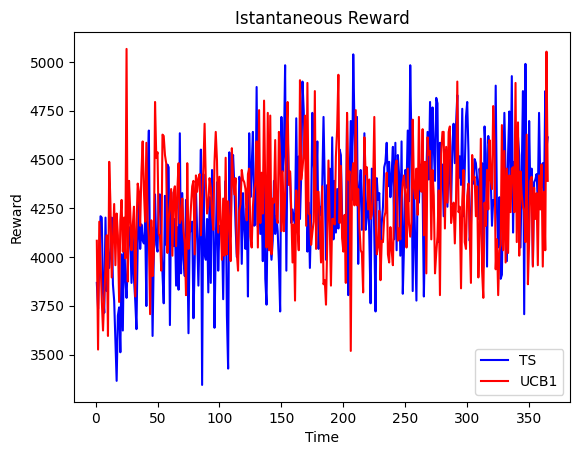

In [3]:
# Plot the results
plt.plot(range(1, T+1), reward_ts, 'b', label='TS')
plt.plot(range(1, T+1), reward_ucb, 'r', label='UCB1')

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Istantaneous Reward')
plt.legend()
plt.show()

### Cumulative reward

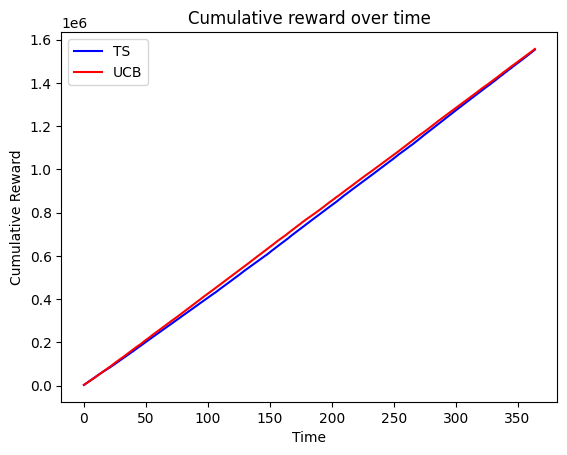

In [4]:
plt.ylabel("Cumulative Reward")
plt.xlabel("Time")
plt.title("Cumulative reward over time")
plt.plot(np.cumsum(np.mean(ts_rewards_per_experiment, axis=0)), 'b', label='TS')
plt.plot(np.cumsum(np.mean(ucb_reward_per_experiment, axis=0)), 'r', label='UCB')
plt.legend()
plt.show()

### Cumulative regret

150 1.1274747474747475


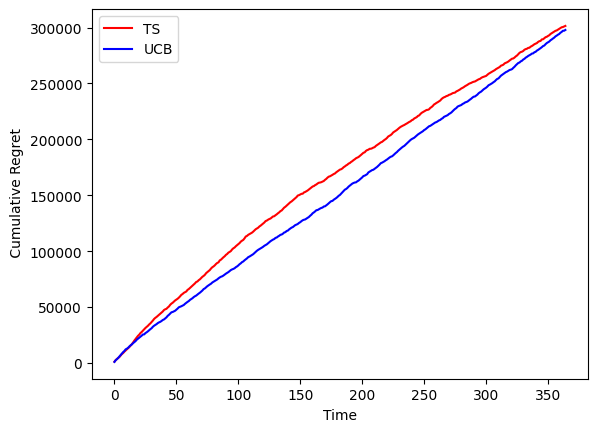

In [5]:
#optimum_price = 150
#optimum_bid = 1.1274747474747475
from utils.clairvoyant_tools import get_optimal_parameters
#opt = 200*140*0.5-140

optimum_price, optimum_bid, opt = get_optimal_parameters(uc1.user_index)
print(optimum_price,optimum_bid)

plt.figure(0)
plt.ylabel(" Cumulative Regret")
plt.xlabel("Time")
plt.plot(np.cumsum(opt - np.array(reward_ts), axis=0), 'r')
plt.plot(np.cumsum(opt - np.array(reward_ucb), axis=0), 'b')
plt.legend(["TS", "UCB"])
plt.show()

### Istantaneous regret

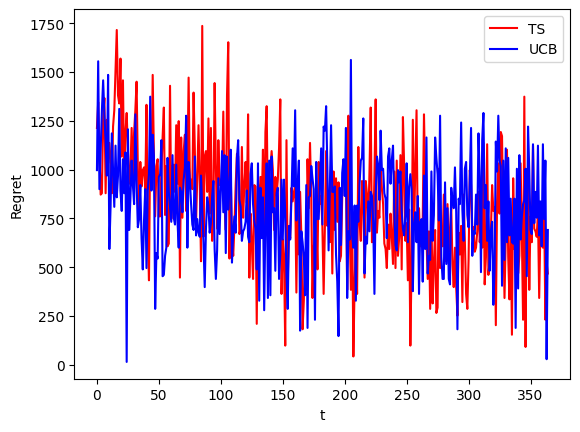

In [6]:
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.mean(opt - np.array(ts_rewards_per_experiment), axis=0), 'r', label='TS')
plt.plot(np.mean(opt - np.array(ucb_reward_per_experiment), axis=0), 'b', label='UCB')
plt.legend()
plt.show()

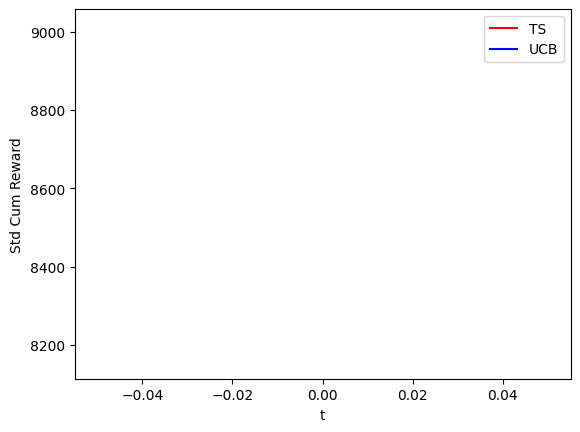

In [8]:
std_cum_reward_ts = np.std(ts_rewards_per_experiment, axis=0)
std_cum_reward_ucb = np.std(ucb_reward_per_experiment, axis=0)

plt.ylabel("Std Cum Reward")
plt.xlabel("t")
plt.plot(np.mean(std_cum_reward_ts, axis=0), 'r', label='TS')
plt.plot(np.mean(std_cum_reward_ts, axis=0), 'b', label='UCB')
plt.legend()
plt.show()